# Delay-Sensitive Plasticity
This notebook provides the analysis leading to the figures presented in the [2023 paper](https://ieeexplore.ieee.org/abstract/document/10191901) on delay-sensitive local plasticity using the BCM rule in distance-based delay networks. This file loads the existing data resulting from the CMA-ES hyperparameter optimization of DDNs and ADDNs. Running a new CMA-ES run can be done using [BCM_experiment.py](BCM_experiment.py).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import pandas as pd

In [3]:
evolution_data = {
    'ESN': {
        'fixed': {'path': "results-2023-paper/2022-12-08_b1_n300_k6_multiple_sequences_random_tau_adaptive_False_delays_False.p"},
        'BCM': {'path': "results-2023-paper/2022-12-05delay_BCM_b25_n300_k6_multiple_sequences_BCM_5_5_seq_random_tau.p"}
    },
    'DDN': {
        'fixed': {'path': "results-2023-paper/2022-12-06delay_BCM_b25_n300_k6_multiple_sequences_BCM_5_5_seq_random_tau.p"},
        'BCM': {'path': "results-2023-paper/2022-12-02delay_BCM_b25_n300_k6_multiple_sequences_BCM_5_5_seq_random_tau.p"}
    }
}


In [4]:
for net_type in evolution_data:
    for adaptive in evolution_data[net_type]:
        evo_path = evolution_data[net_type][adaptive]['path']
        with open(evo_path, 'rb') as f:
            es_dict = pkl.load(f)
        print(net_type + ';' + adaptive)
        evolution_data[net_type][adaptive]['results dict'] = es_dict
        print(es_dict['example net'])
        print(np.max(es_dict['example net'].D))
tau_range = es_dict['tau range']
error_margin = es_dict['error margin']

ESN;fixed
1
ESN;BCM
1.0
DDN;fixed
23
DDN;BCM
22


## Plot of validation scores throughout evolution
Corresponds to figure 2 in the paper.

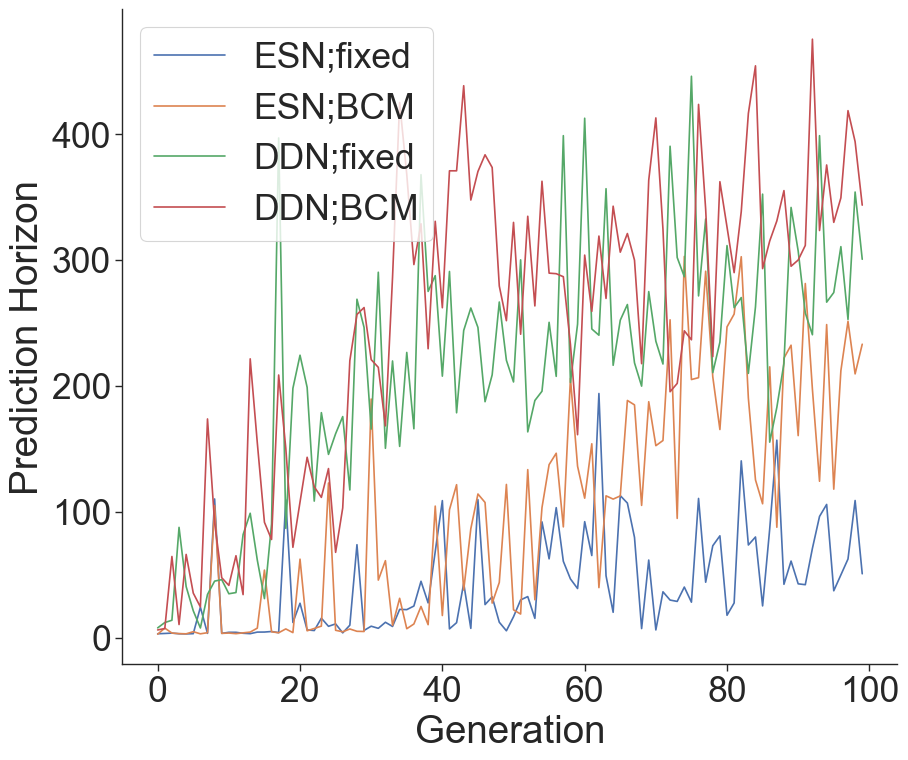

In [5]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=2.9, palette='deep', context='paper', rc=custom_params)
fig, ax = plt.subplots(figsize=(10, 8.5))
colors = ['C0', 'C1', 'C2', 'C3']
i = 0
for net_type in evolution_data:
    for adaptive in evolution_data[net_type]:
        val_mat = evolution_data[net_type][adaptive]['results dict']['validation performance']
        val_mat = np.max(np.mean(val_mat, axis=-1), axis=-1)
        plt.plot(val_mat, label=net_type + ';' + adaptive, color=colors[i])
        i += 1

plt.legend()
plt.xlabel('Generation')
plt.ylabel('Prediction Horizon')
plt.savefig('figures_out/ADDNs_evo.pdf')


## Distribution of validation scores
Because of the messy convergence, let's have a look at how the validation scores are distributed.

<AxesSubplot: xlabel='Generation', ylabel='Prediction Horizon'>

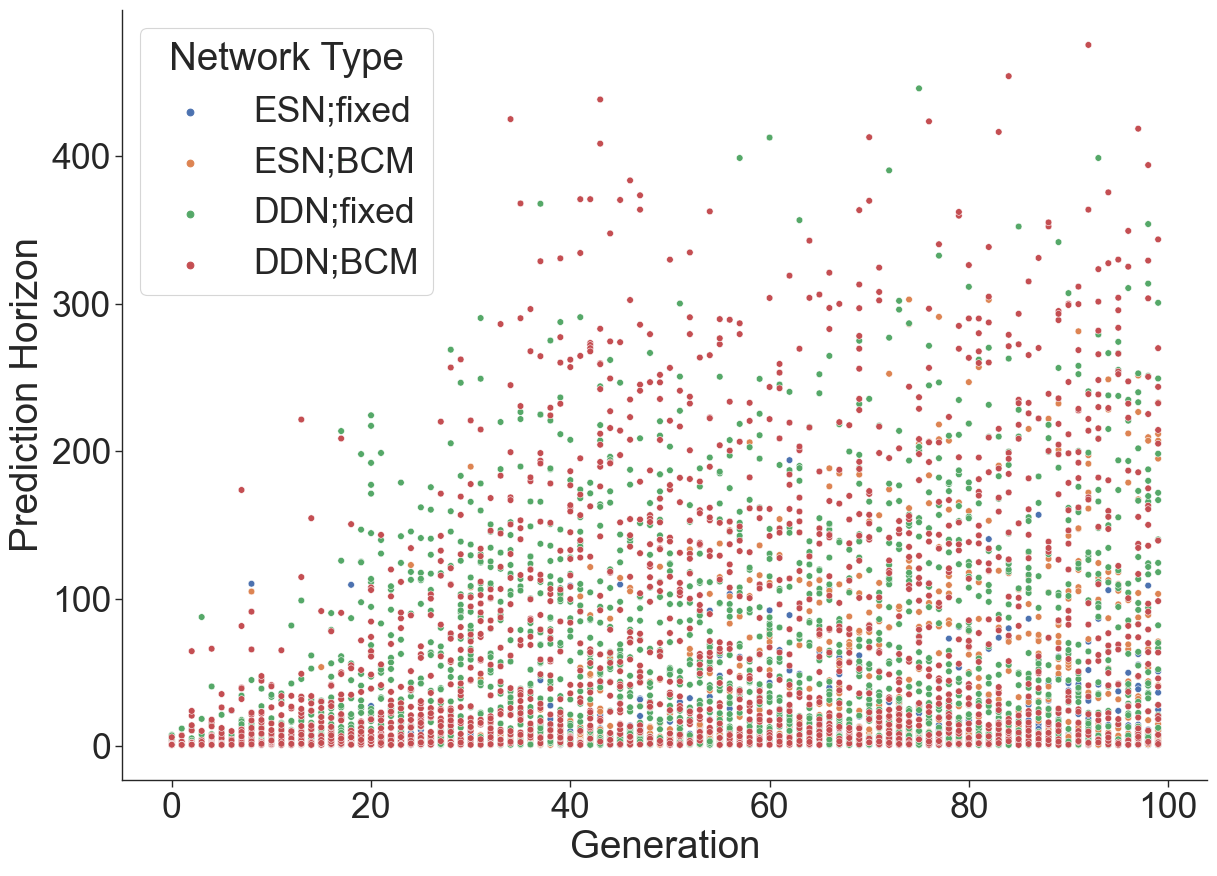

In [6]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=2.9, palette='deep', context='paper', rc=custom_params)
fig, ax = plt.subplots(figsize=(14, 10))
scatter_plot_dict = {
    'Network Type': [],
    'Prediction Horizon': [],
    'Generation': []
}
for i, net_type in enumerate(evolution_data):
    for j, adaptive in enumerate(evolution_data[net_type]):
        val_mat = evolution_data[net_type][adaptive]['results dict']['validation performance']
        val_mat = np.mean(val_mat, axis=-1)
        for gen, pop in enumerate(val_mat):
            scatter_plot_dict['Network Type'] += [net_type + ';' + adaptive] * len(pop)
            scatter_plot_dict['Prediction Horizon'] += list(pop)
            scatter_plot_dict['Generation'] += [gen] * len(pop)

pd_scatter_plot = pd.DataFrame.from_dict(scatter_plot_dict)
sns.scatterplot(pd_scatter_plot, x='Generation', y='Prediction Horizon', hue='Network Type')


## Test scores
Here we load pre-existing test results. Each of the optimized models was trained and tested on the full range of timescales in the task system. We compare how the networks perform for each timescale. Repeating the test process can be done using [testOptimized.py](testOptimized.py).

In [7]:
test_file_path = "results-2023-paper/test-results-2023-paper-original.p"
with open(test_file_path, 'rb') as f:
    test_dict = pkl.load(f)

plot_df_dict = {
    'Model': [],
    'Performance': [],
    'Tau': [],
    'BCM': [],
    'Network Type': []
}
for net_type in test_dict:
    for adaptive in test_dict[net_type]:
        bcm = adaptive == 'BCM'
        for tau in test_dict[net_type][adaptive]:
            scores = test_dict[net_type][adaptive][tau]
            reps = len(scores)
            model_name = net_type + '; ' + adaptive
            plot_df_dict['Model'] += reps * [model_name]
            plot_df_dict['Performance'] += scores
            plot_df_dict['Tau'] += reps * [tau]
            plot_df_dict['BCM'] += reps * [bcm]
            plot_df_dict['Network Type'] += reps * [net_type]

plot_df = pd.DataFrame.from_dict(plot_df_dict)

### Plot as a function of tau for each model type
to show interaction between task timescale (tau) and model types. Corresponds to figure 4 in paper.

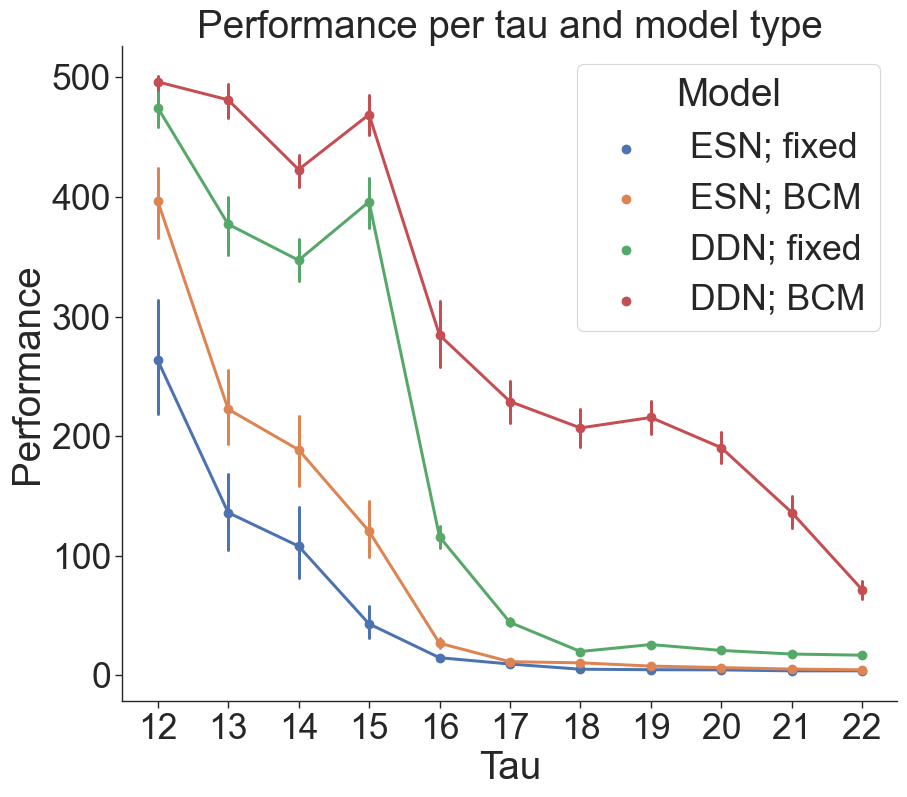

In [8]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=2.9, palette='deep', context='paper', rc=custom_params)
fig, ax = plt.subplots(figsize=(10, 8.5))
ax.set_title("Performance per tau and model type")
sns.pointplot(plot_df, y='Performance', x='Tau', hue='Model', ax=ax)
plt.savefig('figures_out/ADDNs_test_per_tau.pdf')

<AxesSubplot: title={'center': 'Performance averaged over all tau values'}, xlabel='Network Type', ylabel='Performance'>

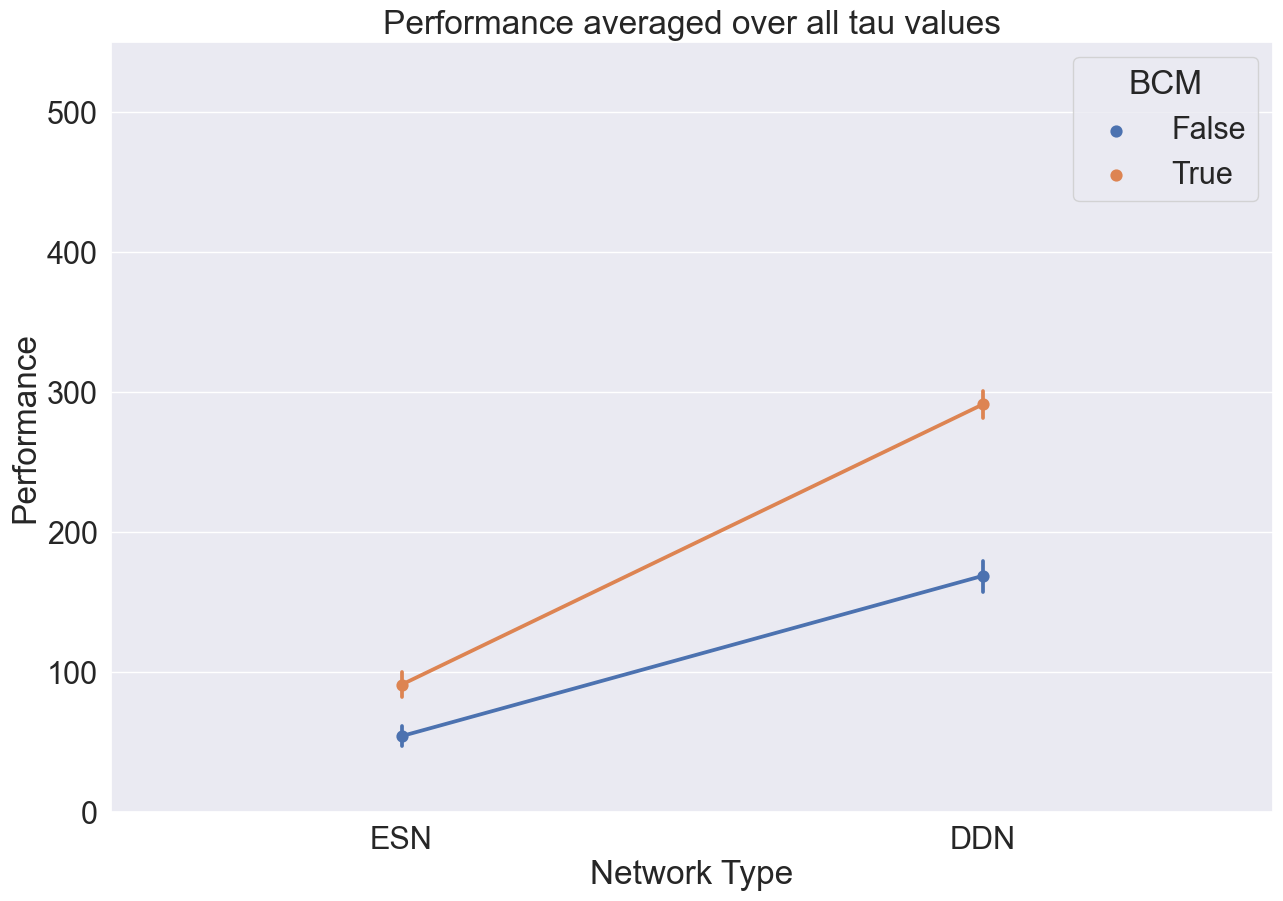

In [9]:
sns.set(font_scale=2)
plt.figure(figsize=(15, 10))
plt.title("Performance averaged over all tau values")
plt.ylim(0, 550)
sns.pointplot(plot_df, y='Performance', x='Network Type', hue='BCM')

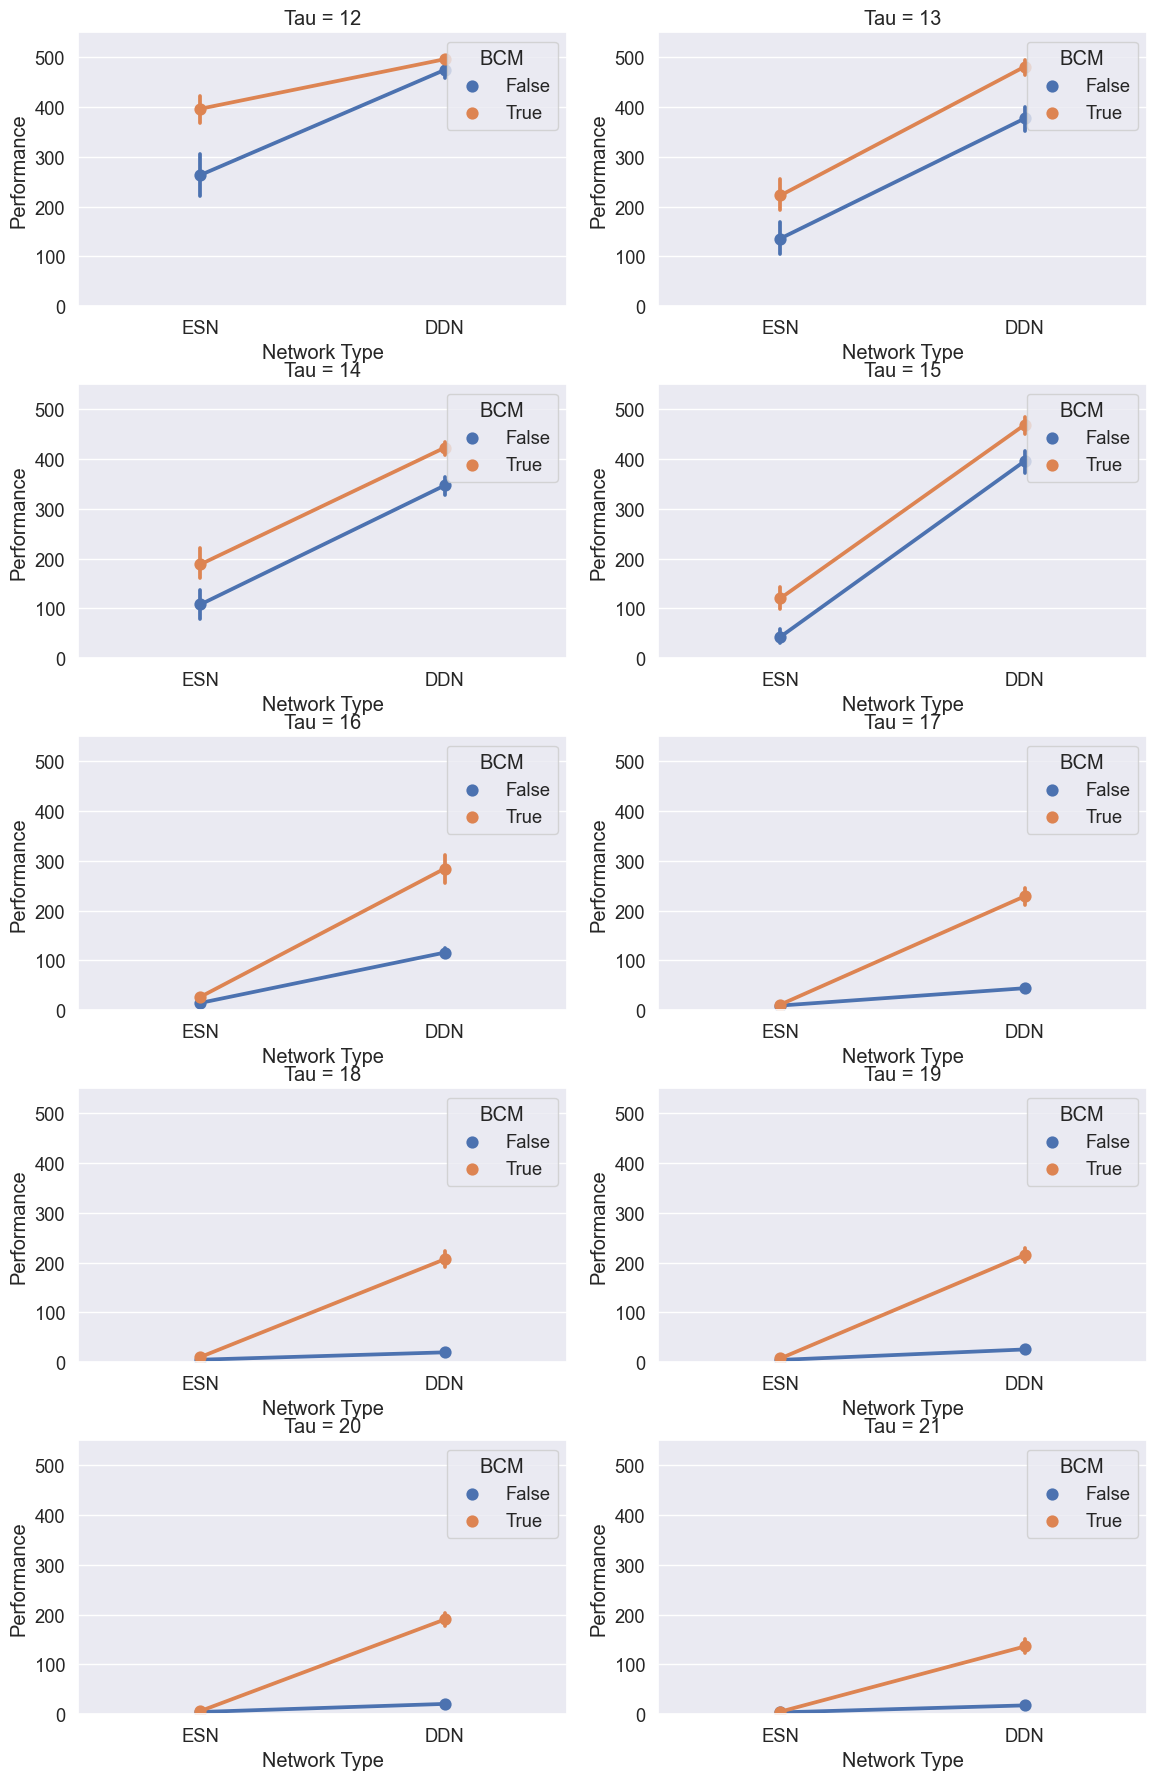

In [10]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(5, 2, figsize=(12, 18))
taus = range(tau_range[0], tau_range[1])

fig.tight_layout(pad=2)
# fig.suptitle("Performance per tau")

for ind, tau in enumerate(taus):
    df = plot_df.loc[plot_df['Tau'] == tau]
    i = ind//2
    j = ind%2
    ax[i, j].set_title("Tau = " + str(tau))
    ax[i, j].set_ylim(0, 550)
    sns.pointplot(df, y='Performance', hue='BCM', x='Network Type', ax=ax[i,j])